In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class SmartOfficeEcoEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array"]}

    def __init__(self, render_mode="rgb_array"):
        self.render_mode = render_mode

        self.COMFORT_RANGE = (22.0, 24.0)

        self.WORK_START = 8
        self.WORK_END = 19

        self.bins_room = np.array([15, 17, 19, 20, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25, 26, 28, 30])
        self.bins_outside = np.array([-10, -5, 0, 3, 6, 9, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40])

        self.ACTION_EFFECTS = {
            0: 0.0,
            1: -0.5, 2: -1.5, 3: -3.0, # Soğutma
            4: 0.8,  # Heat-Low
            5: 2.0,  # Heat-Mid
            6: 4.0   # Heat-High
        }

        self.ENERGY_CONSUMPTION = {
            0: 0.0,

            # Soğutma
            1: 0.2,  # Low
            2: 1.0,  # Mid
            3: 2.5,  # High

            # Isıtma
            4: 0.4,  # Low
            5: 1.5,  # Mid
            6: 4.0   # High
        }

        self.ACTION_VISUALS = {
            0: (0, 0), 1: (-1, 1), 2: (-1, 2), 3: (-1, 3),
            4: (1, 1), 5: (1, 2), 6: (1, 3)
        }

        self.action_space = spaces.Discrete(7)
        self.observation_space = spaces.MultiDiscrete([17, 22, 24])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.room_temp = self.np_random.uniform(18, 28)
        self.outside_temp = self.np_random.uniform(10, 30)
        self.hour = 0
        self.current_energy = 0.0
        self.last_action = 0
        self.step_count = 0
        return self._get_obs(), {"action_mask": np.ones(7, dtype=np.int8)}

    def _get_obs(self):
        room_idx = np.digitize(self.room_temp, self.bins_room)
        out_idx = np.digitize(self.outside_temp, self.bins_outside)
        return np.array([room_idx, out_idx, self.hour], dtype=np.int32)

    def step(self, action):
        self.last_action = action
        change = self.ACTION_EFFECTS[action]
        cost = self.ENERGY_CONSUMPTION[action]
        self.current_energy = cost

        diff = self.outside_temp - self.room_temp
        self.room_temp += diff * 0.05
        self.room_temp += change

        reward = 0.0

        reward -= (cost * 2.0)

        # Mesai Kontrolü
        is_working_hour = self.WORK_START <= self.hour < self.WORK_END
        in_comfort = self.COMFORT_RANGE[0] <= self.room_temp <= self.COMFORT_RANGE[1]

        if is_working_hour:
            if in_comfort:
                reward += 150.0
            else:
                dist = min(abs(self.room_temp - 22.0), abs(self.room_temp - 24.0))
                reward -= (100.0 + dist * 20.0)

        if self.room_temp < 10 or self.room_temp > 35:
            reward -= 50.0

        self.step_count += 1
        self.hour = (self.hour + 1) % 24

        if 6 <= self.hour < 15: self.outside_temp += 0.5
        elif self.hour >= 15 or self.hour < 5: self.outside_temp -= 0.5

        terminated = (self.step_count >= 24)
        return self._get_obs(), reward, terminated, False, {}

    def render(self):
        fig = plt.figure(figsize=(6, 6), dpi=100)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.axis('off')

        in_comfort = self.COMFORT_RANGE[0] <= self.room_temp <= self.COMFORT_RANGE[1]
        bg_color = '#90EE90' if in_comfort else 'orange'

        is_working = self.WORK_START <= self.hour < self.WORK_END
        bg_alpha = 0.8 if is_working else 0.3

        ax.add_patch(patches.Rectangle((1, 1), 8, 8, facecolor=bg_color,
                                       edgecolor="black", lw=3, alpha=bg_alpha))

        status_text = "WORK TIME" if is_working else "OFF-HOURS"
        ax.text(5, 9.2, status_text, fontsize=14, ha='center',
                fontweight='bold', bbox=dict(facecolor='white'))

        ax.add_patch(patches.Rectangle((3.5, 6), 3, 1.5, facecolor="#E0E0E0"))
        ax.text(5, 6.75, "AC UNIT", ha='center', fontsize=10, fontweight='bold')

        mode, level = self.ACTION_VISUALS[self.last_action]
        if level > 0:
            color = "dodgerblue" if mode == -1 else "crimson"
            for i in range(level):
                ax.add_patch(patches.Rectangle(
                    (4 + (i * 0.4) - ((level - 1) * 0.2), 5.9 - (0.5 + i * 0.2)),
                    0.3, 0.5 + i * 0.2, facecolor=color
                ))

        ax.text(2, 8.5, f"{self.hour:02d}:00", fontsize=16, fontweight='bold', bbox=dict(facecolor='white'))
        ax.text(5, 4, f"In: {self.room_temp:.1f}°C", fontsize=22, ha='center', fontweight='bold')
        ax.text(5, 3, f"Out: {self.outside_temp:.1f}°C", fontsize=12, ha='center')

        power_color = 'green' if self.current_energy < 0.5 else 'red'
        ax.text(5, 2, f"Power: {self.current_energy:.1f} kW", fontsize=12, ha='center', color=power_color, fontweight='bold')

        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:, :, :3]
        plt.close(fig)
        return img

def create_office_env():
    return SmartOfficeEcoEnv()

SMART OFFICE AC SYSTEM - ECO-SMART ENVIRONMENT
Observation Space: MultiDiscrete([17 22 24])
Action Space: 7 (0=Off, 1-3=Cool, 4-6=Heat)
Comfort Range: 22.0-24.0°C
Work Hours: 08:00 - 19:00
State Space Size: 17 * 22 * 24 = 8976 states

[TEST STEP]
Action: 3
Observation: [ 7 10  1] (RoomIdx, OutIdx, Hour)
Reward: -5.00
Room Temp: 22.4°C


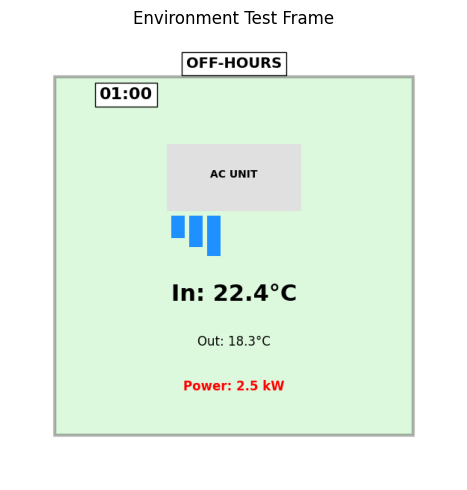


BASELINE: RANDOM AGENT PERFORMANCE

RANDOM AGENT - HOT SUMMER
Total Reward: -1962.2
Total Energy: 31.7 kW
Work Violations: 11/11 hours
Comfort Rate: 0.0%

RANDOM AGENT - MILD SPRING
Total Reward: 171.2
Total Energy: 33.8 kW
Work Violations: 5/11 hours
Comfort Rate: 54.5%

RANDOM AGENT - COLD WINTER
Total Reward: -2562.3
Total Energy: 33.7 kW
Work Violations: 11/11 hours
Comfort Rate: 0.0%


In [2]:
env = create_office_env()
obs, info = env.reset(seed=42)

print("=" * 60)
print("SMART OFFICE AC SYSTEM - ECO-SMART ENVIRONMENT")
print("=" * 60)
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space.n} (0=Off, 1-3=Cool, 4-6=Heat)")
print(f"Comfort Range: {env.COMFORT_RANGE[0]}-{env.COMFORT_RANGE[1]}°C")
print(f"Work Hours: {env.WORK_START:02d}:00 - {env.WORK_END:02d}:00")

# State Space : Room(17) * Out(22) * Hour(24)
total_states = 17 * 22 * 24
print(f"State Space Size: 17 * 22 * 24 = {total_states} states")
print("=" * 60)

# Single Step Test
action = env.action_space.sample()
next_obs, reward, terminated, truncated, info = env.step(action)

print(f"\n[TEST STEP]")
print(f"Action: {action}")
print(f"Observation: {next_obs} (RoomIdx, OutIdx, Hour)")
print(f"Reward: {reward:.2f}")
print(f"Room Temp: {env.room_temp:.1f}°C")

frame = env.render()
plt.figure(figsize=(5, 5))
plt.imshow(frame)
plt.axis("off")
plt.title("Environment Test Frame")
plt.tight_layout()
plt.show()

# Scenario 1: Extreme Hot Summer
HOT_SUMMER = [24, 23, 23, 24, 25, 27, 29, 31, 33, 35, 37, 38,
              38, 37, 36, 34, 32, 31, 30, 29, 28, 27, 26, 25]

# Scenario 2: Mild Spring Day
MILD_SPRING = [16, 15, 15, 16, 17, 18, 20, 22, 24, 25, 26, 27,
               28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]

# Scenario 3: Extreme Cold Winter
COLD_WINTER = [-2, -3, -3, -2, 0, 2, 4, 6, 8, 10, 12, 13,
               14, 13, 12, 10, 8, 6, 5, 3, 2, 0, -1, -2]

SCENARIOS = {
    "Hot Summer": HOT_SUMMER,
    "Mild Spring": MILD_SPRING,
    "Cold Winter": COLD_WINTER
}

def run_random_scenario(env, temps, scenario_name):
    obs, _ = env.reset(seed=42)

    if "Summer" in scenario_name: env.room_temp = 26
    elif "Winter" in scenario_name: env.room_temp = 18
    else: env.room_temp = 22

    total_reward = 0
    total_energy = 0
    fail_count = 0

    work_duration = env.WORK_END - env.WORK_START

    print(f"\n{'='*60}")
    print(f"RANDOM AGENT - {scenario_name.upper()}")
    print(f"{'='*60}")

    for h in range(24):
        env.outside_temp = temps[h]
        env.hour = h

        action = env.action_space.sample()
        obs, reward, terminated, _, _ = env.step(action)
        total_reward += reward
        total_energy += env.current_energy

        if env.WORK_START <= h < env.WORK_END:
            if not (env.COMFORT_RANGE[0] <= env.room_temp <= env.COMFORT_RANGE[1]):
                fail_count += 1

    comfort_rate = ((work_duration - fail_count) / work_duration * 100)

    print(f"Total Reward: {total_reward:.1f}")
    print(f"Total Energy: {total_energy:.1f} kW")
    print(f"Work Violations: {fail_count}/{work_duration} hours")
    print(f"Comfort Rate: {comfort_rate:.1f}%")
    print(f"{'='*60}")

    return total_reward, total_energy, comfort_rate

print("\n" + "="*60)
print("BASELINE: RANDOM AGENT PERFORMANCE")
print("="*60)

for scenario_name, temps in SCENARIOS.items():
    env = create_office_env()
    run_random_scenario(env, temps, scenario_name)


OPTIMIZED Q-LEARNING TRAINING (ECO-SMART MODE)
State Space: 8976 states (Expanded for Hourly Precision)
Training on 3 diverse weather scenarios

 TRAINING IN PROGRESS...
Ep:  4,000 | ε: 0.8521 | Comfort:  90.9% | Energy:  8.1kW | Reward:  1633.7 | NEW RECORD (Better Comfort)!
Ep:  8,000 | ε: 0.7261 | Comfort:  90.9% | Energy:  8.0kW | Reward:  1634.1 | NEW RECORD (Energy Saving)!
Ep: 12,000 | ε: 0.6188 | Comfort:  87.9% | Energy:  8.3kW | Reward:  1549.7 | 
Ep: 16,000 | ε: 0.5273 | Comfort:  84.8% | Energy:  9.1kW | Reward:  1455.4 | 
Ep: 20,000 | ε: 0.4493 | Comfort:  90.9% | Energy:  7.6kW | Reward:  1634.7 | NEW RECORD (Energy Saving)!
Ep: 24,000 | ε: 0.3829 | Comfort:  90.9% | Energy:  7.4kW | Reward:  1635.1 | NEW RECORD (Energy Saving)!
Ep: 28,000 | ε: 0.3263 | Comfort:  87.9% | Energy:  7.0kW | Reward:  1548.4 | 
Ep: 32,000 | ε: 0.2780 | Comfort:  90.9% | Energy:  7.0kW | Reward:  1636.0 | NEW RECORD (Energy Saving)!
Ep: 36,000 | ε: 0.2369 | Comfort:  87.9% | Energy:  7.4kW | R

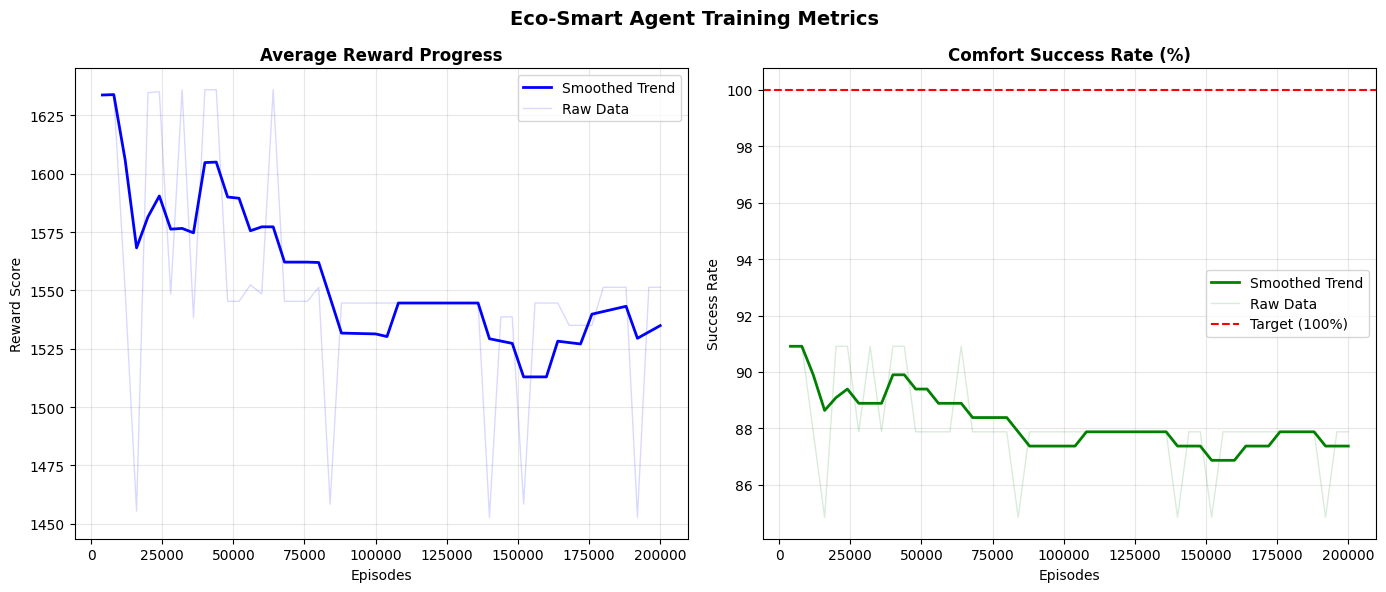

In [3]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt

env = create_office_env()

N_ROOM = 17
N_OUT = 22
N_HOUR = 24

def get_state_size():
    return N_ROOM * N_OUT * N_HOUR  # 8976 state

def state_to_index(obs):
    room, out, hour = obs
    return int((room * N_OUT * N_HOUR) + (out * N_HOUR) + hour)

def evaluate_agent(env, q_table, episodes=10):
    scenario_results = {}

    for scenario_name, temps in SCENARIOS.items():
        total_work_duration = 0
        success_work_duration = 0
        total_rewards = []
        total_energies = []

        for _ in range(episodes):
            obs, _ = env.reset()
            if "Summer" in scenario_name: env.room_temp = 26
            elif "Winter" in scenario_name: env.room_temp = 18
            else: env.room_temp = 22

            terminated = False
            ep_reward = 0
            ep_energy = 0

            for h in range(24):
                env.outside_temp = temps[h]
                env.hour = h

                obs = env._get_obs()
                state = state_to_index(obs)

                action = np.argmax(q_table[state])
                obs, reward, terminated, _, _ = env.step(action)

                if env.WORK_START <= env.hour < env.WORK_END:
                    total_work_duration += 1
                    if env.COMFORT_RANGE[0] <= env.room_temp <= env.COMFORT_RANGE[1]:
                        success_work_duration += 1

                ep_reward += reward
                ep_energy += env.current_energy

            total_rewards.append(ep_reward)
            total_energies.append(ep_energy)

        success_rate = (success_work_duration / total_work_duration * 100) if total_work_duration > 0 else 0
        scenario_results[scenario_name] = {
            'reward': np.mean(total_rewards),
            'comfort': success_rate,
            'energy': np.mean(total_energies)
        }

    avg_reward = np.mean([r['reward'] for r in scenario_results.values()])
    avg_comfort = np.mean([r['comfort'] for r in scenario_results.values()])
    avg_energy = np.mean([r['energy'] for r in scenario_results.values()])

    return avg_reward, avg_comfort, avg_energy, scenario_results

print("\n" + "=" * 60)
print("OPTIMIZED Q-LEARNING TRAINING (ECO-SMART MODE)")
print("=" * 60)
print(f"State Space: {get_state_size()} states (Expanded for Hourly Precision)")
print("Training on 3 diverse weather scenarios")
print("=" * 60)

state_size = get_state_size()
q_table = np.zeros([state_size, 7])

alpha = 0.1
gamma = 0.995
epsilon = 1.0
epsilon_decay = 0.99996
epsilon_min = 0.01

num_episodes = 200000
eval_every = 4000

print("\n TRAINING IN PROGRESS...")
print("=" * 60)

best_score = -np.inf
best_comfort = 0
best_energy = float('inf')

hist_ep = []
hist_reward = []
hist_comfort = []
hist_energy = []

start_time = time.time()

for ep in range(1, num_episodes + 1):

    scenario_temps = list(SCENARIOS.values())[ep % 3]

    obs, _ = env.reset()
    env.room_temp = np.random.uniform(18, 28)

    env.outside_temp = scenario_temps[0]
    env.hour = 0
    obs = env._get_obs()
    state = state_to_index(obs)

    terminated = False
    step = 0

    while not terminated:
        env.outside_temp = scenario_temps[step]
        env.hour = step

        obs = env._get_obs()
        state = state_to_index(obs)

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_obs, reward, terminated, _, _ = env.step(action)
        next_state = state_to_index(next_obs)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        q_table[state, action] = old_value + alpha * (reward + gamma * next_max - old_value)

        step += 1

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if ep % eval_every == 0:
        score, comfort, energy, _ = evaluate_agent(env, q_table, episodes=3)

        hist_ep.append(ep)
        hist_reward.append(score)
        hist_comfort.append(comfort)
        hist_energy.append(energy)

        save_msg = ""
        if comfort > best_comfort:
            best_comfort = comfort
            best_energy = energy
            best_score = score
            np.save("best_q_table.npy", q_table)
            save_msg = "NEW RECORD (Better Comfort)!"
        elif comfort == best_comfort and energy < best_energy:
            best_energy = energy
            best_score = score
            np.save("best_q_table.npy", q_table)
            save_msg = "NEW RECORD (Energy Saving)!"

        print(f"Ep: {ep:6,d} | ε: {epsilon:.4f} | Comfort: {comfort:5.1f}% | "
              f"Energy: {energy:4.1f}kW | Reward: {score:7.1f} | {save_msg}")

elapsed_total = time.time() - start_time
print("\n" + "=" * 60)
print(f" TRAINING COMPLETE")
print(f" Duration: {elapsed_total/60:.1f} minutes")
print(f" Best Comfort: {best_comfort:.1f}%")
print(f" Best Energy: {best_energy:.1f} kW")
print(f" Best Reward: {best_score:.1f}")
print("=" * 60 + "\n")

window_size = 5
def moving_average(data, window):
    if len(data) < window: return data
    return [np.mean(data[max(0, i-window):i+1]) for i in range(len(data))]

smooth_rewards = moving_average(hist_reward, window_size)
smooth_comfort = moving_average(hist_comfort, window_size)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_ep, smooth_rewards, color='blue', linewidth=2, label='Smoothed Trend')
plt.plot(hist_ep, hist_reward, color='blue', alpha=0.15, linewidth=1, label='Raw Data')
plt.title(f"Average Reward Progress", fontweight='bold')
plt.xlabel("Episodes")
plt.ylabel("Reward Score")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(hist_ep, smooth_comfort, color='green', linewidth=2, label='Smoothed Trend')
plt.plot(hist_ep, hist_comfort, color='green', alpha=0.15, linewidth=1, label='Raw Data')
plt.axhline(y=100, color='r', linestyle='--', label='Target (100%)', linewidth=1.5)
plt.title(f"Comfort Success Rate (%)", fontweight='bold')
plt.xlabel("Episodes")
plt.ylabel("Success Rate")
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle("Eco-Smart Agent Training Metrics", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

'best_q_table.npy' loaded successfully.


HOT SUMMER - ECO-SMART AGENT PERFORMANCE
HOUR  | STATUS     | OUT°C    | IN°C         | ACTION          | ENERGY  
00:00 | OFF-HOUR   |  24.0    |  26.0 -    | OFF             | 0.0 kW
01:00 | OFF-HOUR   |  23.0    |  25.9 -    | OFF             | 0.0 kW
02:00 | OFF-HOUR   |  23.0    |  25.8 -    | OFF             | 0.0 kW
03:00 | OFF-HOUR   |  24.0    |  25.6 -    | OFF             | 0.0 kW
04:00 | OFF-HOUR   |  25.0    |  25.5 -    | OFF             | 0.0 kW
05:00 | OFF-HOUR   |  27.0    |  25.5 -    | OFF             | 0.0 kW
06:00 | OFF-HOUR   |  29.0    |  25.6 -    | OFF             | 0.0 kW
07:00 | OFF-HOUR   |  31.0    |  25.8 -    | OFF             | 0.0 kW
08:00 | WORK       |  33.0    |  26.0 ✗    | Cool-High       | 2.5 kW
09:00 | WORK       |  35.0    |  23.4 ✓    | Cool-Low        | 0.2 kW
10:00 | WORK       |  37.0    |  23.4 ✓    | Cool-Low        | 0.2 kW
11:00 | WORK       |  38.0    |  23.6 ✓    | Cool-Mid        | 1.0 kW
12:

/tmp/ipython-input-895840485.py:170: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(ws, we, color='none', edgecolor='black', linestyle='--', linewidth=1.5)


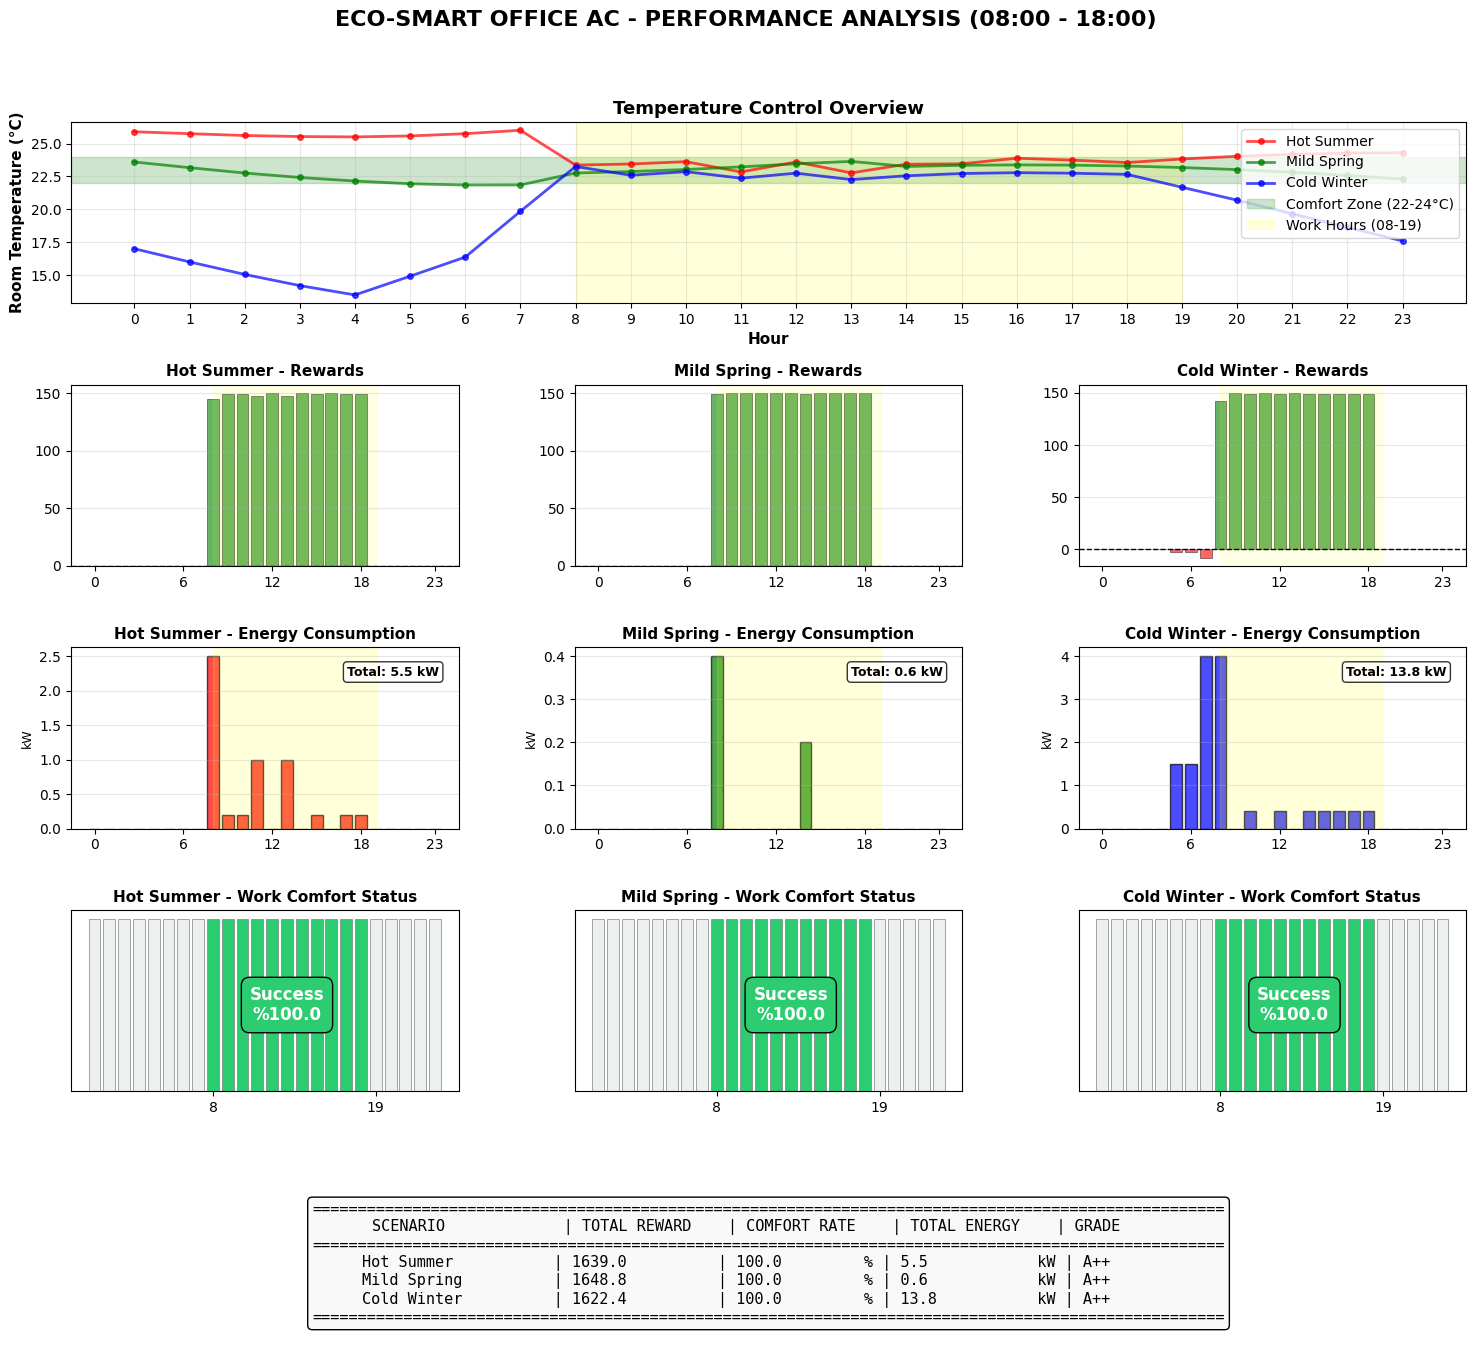


 SAVING ANIMATIONS...
 Saved: ecosmart_office_hot_summer.gif
 Saved: ecosmart_office_mild_spring.gif
 Saved: ecosmart_office_cold_winter.gif

 Displaying Hot Summer scenario animation...


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML

def state_to_index(obs):
    room, out, hour = obs
    return int((room * 22 * 24) + (out * 24) + hour)

try:
    best_q = np.load("best_q_table.npy")
    print("'best_q_table.npy' loaded successfully.\n")
except:
    print("'best_q_table.npy' not found. Using current in-memory q_table or creating dummy.\n")
    try:
        best_q = q_table
    except NameError:
        print("Error: No q_table found. Initializing empty table for demo.")
        best_q = np.zeros((8976, 7))

def show_animation(frames):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(frames[0])
    def update(frame):
        im.set_array(frame)
        return [im]
    anim = animation.FuncAnimation(fig, update, frames=frames, interval=250, blit=True)
    plt.close(fig)
    return anim

def run_office_scenario_with_anim(env, q_table, temps, scenario_name):
    obs, _ = env.reset(seed=42)

    if "Summer" in scenario_name: env.room_temp = 26
    elif "Winter" in scenario_name: env.room_temp = 18
    else: env.room_temp = 24

    history = {
        "hours": [], "room_temp": [], "outside_temp": [],
        "actions": [], "rewards": [], "energy": []
    }
    frames = []

    ACTION_NAMES = ["OFF", "Cool-Low", "Cool-Mid", "Cool-High",
                    "Heat-Low", "Heat-Mid", "Heat-High"]

    print(f"\n{'='*85}")
    print(f"{scenario_name.upper()} - ECO-SMART AGENT PERFORMANCE")
    print(f"{'='*85}")
    print(f"{'HOUR':<5} | {'STATUS':<10} | {'OUT°C':<8} | {'IN°C':<12} | "
          f"{'ACTION':<15} | {'ENERGY':<8}")
    print(f"{'='*85}")

    for h in range(24):
        env.outside_temp = temps[h]
        env.hour = h

        obs = env._get_obs()
        state = state_to_index(obs)
        action = np.argmax(q_table[state])

        is_working = env.WORK_START <= h < env.WORK_END
        status_str = "WORK" if is_working else "OFF-HOUR"

        act_str = ACTION_NAMES[action]
        cost = env.ENERGY_CONSUMPTION[action]

        if is_working:
            comfort_icon = "✓" if env.COMFORT_RANGE[0] <= env.room_temp <= env.COMFORT_RANGE[1] else "✗"
        else:
            comfort_icon = "-"

        print(f"{h:02d}:00 | {status_str:<10} | {env.outside_temp:5.1f}    | "
              f"{env.room_temp:5.1f} {comfort_icon:<4} | {act_str:<15} | {cost:.1f} kW")

        obs, reward, terminated, _, _ = env.step(action)
        frames.append(env.render())

        history["hours"].append(h)
        history["room_temp"].append(env.room_temp)
        history["outside_temp"].append(env.outside_temp)
        history["actions"].append(action)
        history["rewards"].append(reward)
        history["energy"].append(env.current_energy)

    print(f"{'='*85}\n")
    return history, frames

def plot_comprehensive_dashboard(all_histories, env_ref):
    fig = plt.figure(figsize=(18, 16))
    gs = fig.add_gridspec(5, 3, hspace=0.45, wspace=0.3)

    scenario_colors = {'Hot Summer': 'red', 'Mild Spring': 'green', 'Cold Winter': 'blue'}

    ws, we = env_ref.WORK_START, env_ref.WORK_END
    work_duration = we - ws

    ax1 = fig.add_subplot(gs[0, :])
    for scenario_name, history in all_histories.items():
        hours = history["hours"]
        room_temps = history["room_temp"]
        ax1.plot(hours, room_temps, '-o', linewidth=2, markersize=4,
                label=scenario_name, color=scenario_colors[scenario_name], alpha=0.7)

    ax1.axhspan(22, 24, color='green', alpha=0.2, label='Comfort Zone (22-24°C)')
    ax1.axvspan(ws, we, color='yellow', alpha=0.15, label=f'Work Hours ({ws:02d}-{we:02d})')

    ax1.set_xlabel('Hour', fontweight='bold', fontsize=11)
    ax1.set_ylabel('Room Temperature (°C)', fontweight='bold', fontsize=11)
    ax1.set_title('Temperature Control Overview', fontweight='bold', fontsize=13)
    ax1.set_xticks(range(0, 24))
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)

    for idx, (scenario_name, history) in enumerate(all_histories.items()):
        ax = fig.add_subplot(gs[1, idx])
        hours = history["hours"]
        rewards = history["rewards"]

        colors = ['green' if r > 0 else 'red' for r in rewards]
        ax.bar(hours, rewards, color=colors, alpha=0.6, edgecolor='black', linewidth=0.5)

        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.axvspan(ws, we, color='yellow', alpha=0.1)
        ax.set_title(f'{scenario_name} - Rewards', fontweight='bold', fontsize=11)
        ax.set_xticks([0, 6, 12, 18, 23])
        ax.grid(True, alpha=0.3, axis='y')

    for idx, (scenario_name, history) in enumerate(all_histories.items()):
        ax = fig.add_subplot(gs[2, idx])
        hours = history["hours"]
        energies = history["energy"]

        ax.bar(hours, energies, color=scenario_colors[scenario_name], alpha=0.7, edgecolor='black')
        ax.axvspan(ws, we, color='yellow', alpha=0.15)
        ax.set_title(f'{scenario_name} - Energy Consumption', fontweight='bold', fontsize=11)
        ax.set_ylabel('kW', fontsize=9)
        ax.set_xticks([0, 6, 12, 18, 23])
        ax.grid(True, alpha=0.3, axis='y')

        total_e = sum(energies)
        ax.text(0.95, 0.90, f'Total: {total_e:.1f} kW', transform=ax.transAxes,
               fontsize=9, fontweight='bold', va='top', ha='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    for idx, (scenario_name, history) in enumerate(all_histories.items()):
        ax = fig.add_subplot(gs[3, idx])
        hours = history["hours"]
        room_temps = history["room_temp"]

        status_colors = []
        violation_count = 0

        for h, t in zip(hours, room_temps):
            if ws <= h < we:
                if 22.0 <= t <= 24.0:
                    status_colors.append('#2ecc71')
                else:
                    status_colors.append('#e74c3c')
                    violation_count += 1
            else:
                status_colors.append('#ecf0f1')

        ax.bar(hours, [1]*24, color=status_colors, edgecolor='gray', linewidth=0.5)

        ax.set_yticks([])
        ax.set_xticks([ws, we])
        ax.axvspan(ws, we, color='none', edgecolor='black', linestyle='--', linewidth=1.5)
        ax.set_title(f'{scenario_name} - Work Comfort Status', fontweight='bold', fontsize=11)

        success_rate = ((work_duration - violation_count) / work_duration) * 100

        box_color = '#2ecc71' if success_rate >= 90 else '#e74c3c'
        ax.text(13, 0.5, f"Success\n%{success_rate:.1f}", ha='center', va='center',
                fontsize=12, fontweight='bold', color='white',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=box_color, alpha=1.0))

    ax_summary = fig.add_subplot(gs[4, :])
    ax_summary.axis('off')

    summary_text = "=" * 100 + "\n"
    summary_text += f"{'SCENARIO':<20} | {'TOTAL REWARD':<15} | {'COMFORT RATE':<15} | {'TOTAL ENERGY':<15} | {'GRADE':<10}\n"
    summary_text += "=" * 100 + "\n"

    for scenario_name, history in all_histories.items():
        rewards = history["rewards"]
        room_temps = history["room_temp"]
        energies = history["energy"]

        total_reward = sum(rewards)

        work_hours_comfort = sum([1 for i in range(ws, we) if 22.0 <= room_temps[i] <= 24.0])
        comfort_rate = (work_hours_comfort / work_duration) * 100
        total_energy = sum(energies)

        if comfort_rate >= 99: grade = "A++"
        elif comfort_rate >= 90: grade = "A"
        elif comfort_rate >= 80: grade = "B"
        else: grade = "C"

        summary_text += f"{scenario_name:<20} | {total_reward:<15.1f} | {comfort_rate:<14.1f}% | "
        summary_text += f"{total_energy:<14.1f} kW | {grade:<10}\n"

    summary_text += "=" * 100

    ax_summary.text(0.5, 0.5, summary_text, transform=ax_summary.transAxes,
                   fontsize=11, family='monospace', va='center', ha='center',
                   bbox=dict(boxstyle='round', facecolor='#f9f9f9', edgecolor='black', linewidth=1))

    plt.suptitle('ECO-SMART OFFICE AC - PERFORMANCE ANALYSIS (08:00 - 18:00)',
                fontsize=16, fontweight='bold', y=0.95)
    plt.savefig('eko_ofis_analiz_sonuclari.png', dpi=300, bbox_inches='tight')
    plt.show()


all_histories = {}
all_animations = {}
env_ref = create_office_env()

for scenario_name, temps in SCENARIOS.items():
    env = create_office_env()
    history, frames = run_office_scenario_with_anim(env, best_q, temps, scenario_name)
    all_histories[scenario_name] = history
    all_animations[scenario_name] = show_animation(frames)

plot_comprehensive_dashboard(all_histories, env_ref)

print("\n" + "=" * 60)
print(" SAVING ANIMATIONS...")
print("=" * 60)
for scenario_name, anim in all_animations.items():
    filename = f"ecosmart_office_{scenario_name.lower().replace(' ', '_')}.gif"
    try:
        anim.save(filename, writer="pillow", fps=4)
        print(f" Saved: {filename}")
    except Exception as e:
        print(f" Error saving {filename}: {e}")
print("=" * 60)

print("\n Displaying Hot Summer scenario animation...")
HTML(all_animations["Hot Summer"].to_jshtml())